# はじめに

このノートではLightGBMを理解するために、LightGBMと同じくらい使用頻度の高いXGboostのアルゴリズムについても理解を深めておく。LightGBMの特徴については別のノートで取り上げる予定ではあるが、XGboostの利点を多く備えているのがLightGBMでもあるので、まずはXGboostを理解する。下記のmeanxaiの動画を参考にしている。

- [[MXML-11-04] Extreme Gradient Boosting (XGBoost) [4/9] - Classification: Training & Predict process - YouTube](https://www.youtube.com/watch?v=ud7kJv5csxw&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=12)
- [[MXML-11-05] Extreme Gradient Boosting (XGBoost) [5/9] - Classification: Algorithm analysis - YouTube](https://www.youtube.com/watch?v=e_1TJD8tHgE&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=11)
- [[MXML-11-06] Extreme Gradient Boosting (XGBoost) [6/9] - Implement the classification from scratch - YouTube](https://www.youtube.com/watch?v=oKLBon15bTc&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=10)

今回はXGboostのアルゴリズムを理解し、実際に実装することを目的にする。

## XGboostのアルゴリズム

前回のノートでは、回帰の場合のアルゴリズムを理解するためにスクラッチでコードを書いた。今回は分類のアルゴリズムを理解し、同じくコードを書いて実装することを目的にしている。

<img src='BoostingClassP1.png'>
<img src='BoostingClassP2.png'>
<img src='BoostingClassP3.png'>
<img src='BoostingClassP4.png'>
<img src='BoostingClassP5.png'>

## XGboostを再現する

ここまででXGboostのアルゴリズムを理解できたので、実際にコードに起こして、さらに理解を深めていく。下記を参考にしている。

- [[MXML-11-06] Extreme Gradient Boosting (XGBoost) [6/9] - Implement the classification from scratch - YouTube](https://www.youtube.com/watch?v=oKLBon15bTc&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=10)

### Base Learner

In [1]:
import numpy as np
from collections import Counter
import copy

from sklearn.datasets import make_blobs
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


class MyXGBClassificationTree:
    def __init__(self, max_depth, reg_lambda, prune_gamma):
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.prune_gamma = prune_gamma
        self.estimator1 = None
        self.estimator2 = None
        self.feature = None
        self.residual = None
        self.prev_yhat = None

    def node_split(self, did):
        r = self.reg_lambda
        max_gain = -np.inf
        d = self.feature.shape[1]
        G = self.residual[did].sum()
        H = (self.prev_yhat[did]*(1. - self.prev_yhat[did])).sum()
        p_score = (G ** 2) / (H + r)

        for k in range(d):
            GL = HL = 0.0
            x_feat = self.feature[did, k]
            x_uniq = np.unique(x_feat)
            s_point = [np.mean([x_uniq[i-1], x_uniq[i]]) for i in range(1, len(x_uniq))]
            l_bound = -np.inf

            for j in s_point:
                left = did[np.where(np.logical_and(x_feat > l_bound, x_feat <= j))[0]]
                right = did[np.where(x_feat > j)[0]]
                GL += self.residual[left].sum()
                HL += (self.prev_yhat[left] * (1. - self.prev_yhat[left])).sum()
                GR = G - GL
                HR = H - HL
                gain = (GL**2)/(HL + r) + (GR**2)/(HR + r) - p_score

                if gain > max_gain:
                    max_gain = gain
                    b_fid = k
                    b_point = j
                l_bound = j

        if max_gain >= self.prune_gamma:
            x_feat = self.feature[did, b_fid]
            b_left = did[np.where(x_feat <= b_point)[0]]
            b_right = did[np.where(x_feat > b_point)[0]]
            return {'fid': b_fid, 'split_point': b_point, 'gain': max_gain, 'left': b_left, 'right': b_right}
        else:
            return np.nan

    def recursive_split(self, node, curr_depth):
        left = node['left']
        right = node['right']
        
        if curr_depth >= self.max_depth: return
        
        s = self.node_split(left)
        if isinstance(s, dict):
            node['left'] = s
            self.recursive_split(node['left'], curr_depth+1)
        
        s = self.node_split(right)
        if isinstance(s, dict):
            node['right'] = s
            self.recursive_split(node['right'], curr_depth+1)

    def output_value(self, did):
        r = self.residual[did]
        H = (self.prev_yhat[did]*(1. - self.prev_yhat[did])).sum()
        return np.sum(r) / (H + self.reg_lambda)

    def output_leaf(self, d):
        if isinstance(d, dict):
            for key, value in d.items():
                if key == 'left' or key == 'right':
                    rtn = self.output_leaf(value)
                    if rtn[0] == 1:
                        d[key] = rtn[1]
            return 0, 0
        else:
            return 1, self.output_value(d)

    def fit(self, x, y, prev_yhat):
        self.feature = x
        self.residual = y
        self.prev_yhat = prev_yhat

        root = self.node_split(np.arange(x.shape[0]))
        if isinstance(root, dict):
            self.recursive_split(root, curr_depth=1)
            self.estimator1 = root

        if isinstance(self.estimator1, dict):
            self.estimator2 = copy.deepcopy(self.estimator1)
            self.output_leaf(self.estimator2)

        return self.estimator2

    def x_predict(self, p, x):
        if x[p['fid']] <= p['split_point']:
            if isinstance(p['left'], dict):
                return self.x_predict(p['left'], x)
            else:
                return p['left']
        else:
            if isinstance(p['right'], dict):
                return self.x_predict(p['right'], x)
            else:
                return p['right']

    def predict(self, x_test):
        p = self.estimator2
        
        if isinstance(p, dict):
            y_pred = [self.x_predict(p, x) for x in x_test]
            return np.array(y_pred)
        else:
            return self.prev_yhat * x_test.shape[0]

### XGBoost分類

In [2]:

class MyXGBClassifier:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.3, prune_gamma=0.0, reg_lambda=0.0, base_score=0.5):
        self.n_estimators = n_estimators
        self.max_depth    = max_depth
        self.eta          = learning_rate
        self.prune_gamma  = prune_gamma
        self.reg_lambda   = reg_lambda
        self.base_score   = base_score
        self.estimator1   = dict()
        self.estimator2   = dict()
        self.models       = []
        self.loss         = []

    def F2P(self, x):
        return 1. / (1. + np.exp(-x))

    def fit(self, x, y):
        F0 = np.log(self.base_score / (1. - self.base_score))
        Fm = np.repeat(F0, x.shape[0])
        y_hat = self.F2P(Fm)

        self.models, self.loss = [], []
        for m in range(self.n_estimators):
            residual = y - y_hat
            model = MyXGBClassificationTree(max_depth=self.max_depth, reg_lambda=self.reg_lambda, prune_gamma=self.prune_gamma)
            model.fit(x, residual, y_hat)
            gamma = model.predict(x)
            Fm = Fm + self.eta * gamma
            y_hat = self.F2P(Fm)
            self.models.append(model)
            self.loss.append(-(y * np.log(y_hat + 1e-8) + (1. - y) * np.log(1. - y_hat + 1e-8)).sum())
        return self.loss

    def predict(self, x_test, proba=False):
        Fm = np.zeros(shape=(x_test.shape[0],)) + self.base_score
        for model in self.models:
            Fm += self.eta * model.predict(x_test)
        y_prob = self.F2P(Fm)
        
        if proba:
            return y_prob
        else:
            y_pred = (y_prob > 0.5).astype('uint8')
            return y_pred



### Generate Sample Data

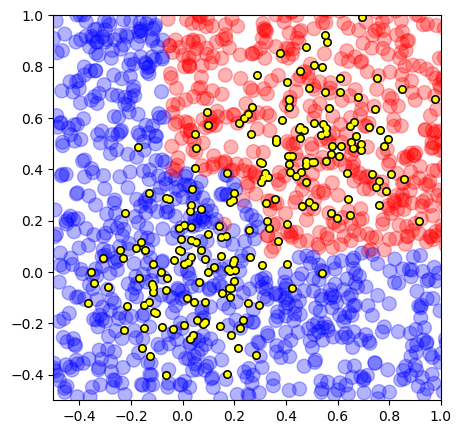

In [23]:

x, y = make_blobs(n_samples=200, n_features=2, centers=[[0., 0.], [0.5, 0.5]], cluster_std=0.18, center_box=(-1., 1.))

def plot_prediction(x, y, x_test, y_pred):
    plt.figure(figsize=(5, 5))
    color = ['red' if a == 1 else 'blue' for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color, alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=30, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

### Run the model

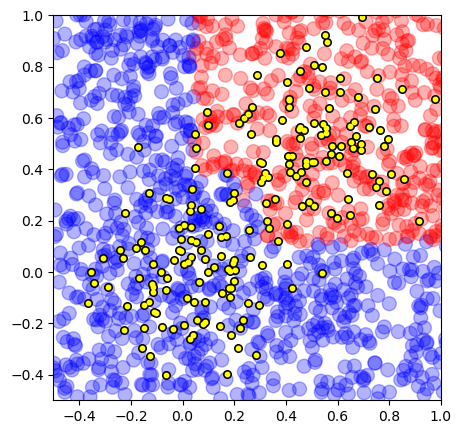

In [24]:

xg_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='exact',
    n_estimators=n_tree,
    max_depth=n_depth,
    learning_rate=eta,
    gamma=prune_gamma,
    reg_lambda=reg_lambda,
    base_score=y_init
)

xg_model.fit(x, y)
y_pred = xg_model.predict(x_test)

# 黄色い点はトレーニングデータ
# 青(yhat=0)と赤(yhat=1)はテストデータ
plot_prediction(x, y, x_test, y_pred)